In [1]:
!nvidia-smi

Sat Jan 31 18:33:17 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
%pip install -q "ultralytics>=8.4.0" supervision roboflow

!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.9/112.6 GB disk)


In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

/content/datasets


In [5]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("dandata").project("security_surveillance")
version = project.version(1)
dataset = version.download("yolo26")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Security_Surveillance-1 in yolo26:: 100%|██████████| 10924/10924 [00:02<00:00, 5142.93it/s]


In [9]:
%cd {HOME}

!yolo task=detect mode=train model=yolo26m.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/Security_Surveillance-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

In [10]:
!ls {HOME}/runs/detect/train2/

args.yaml			 labels.jpg		val_batch0_pred.jpg
BoxF1_curve.png			 results.csv		val_batch1_labels.jpg
BoxP_curve.png			 results.png		val_batch1_pred.jpg
BoxPR_curve.png			 train_batch0.jpg	val_batch2_labels.jpg
BoxR_curve.png			 train_batch1.jpg	val_batch2_pred.jpg
confusion_matrix_normalized.png  train_batch2.jpg	weights
confusion_matrix.png		 val_batch0_labels.jpg


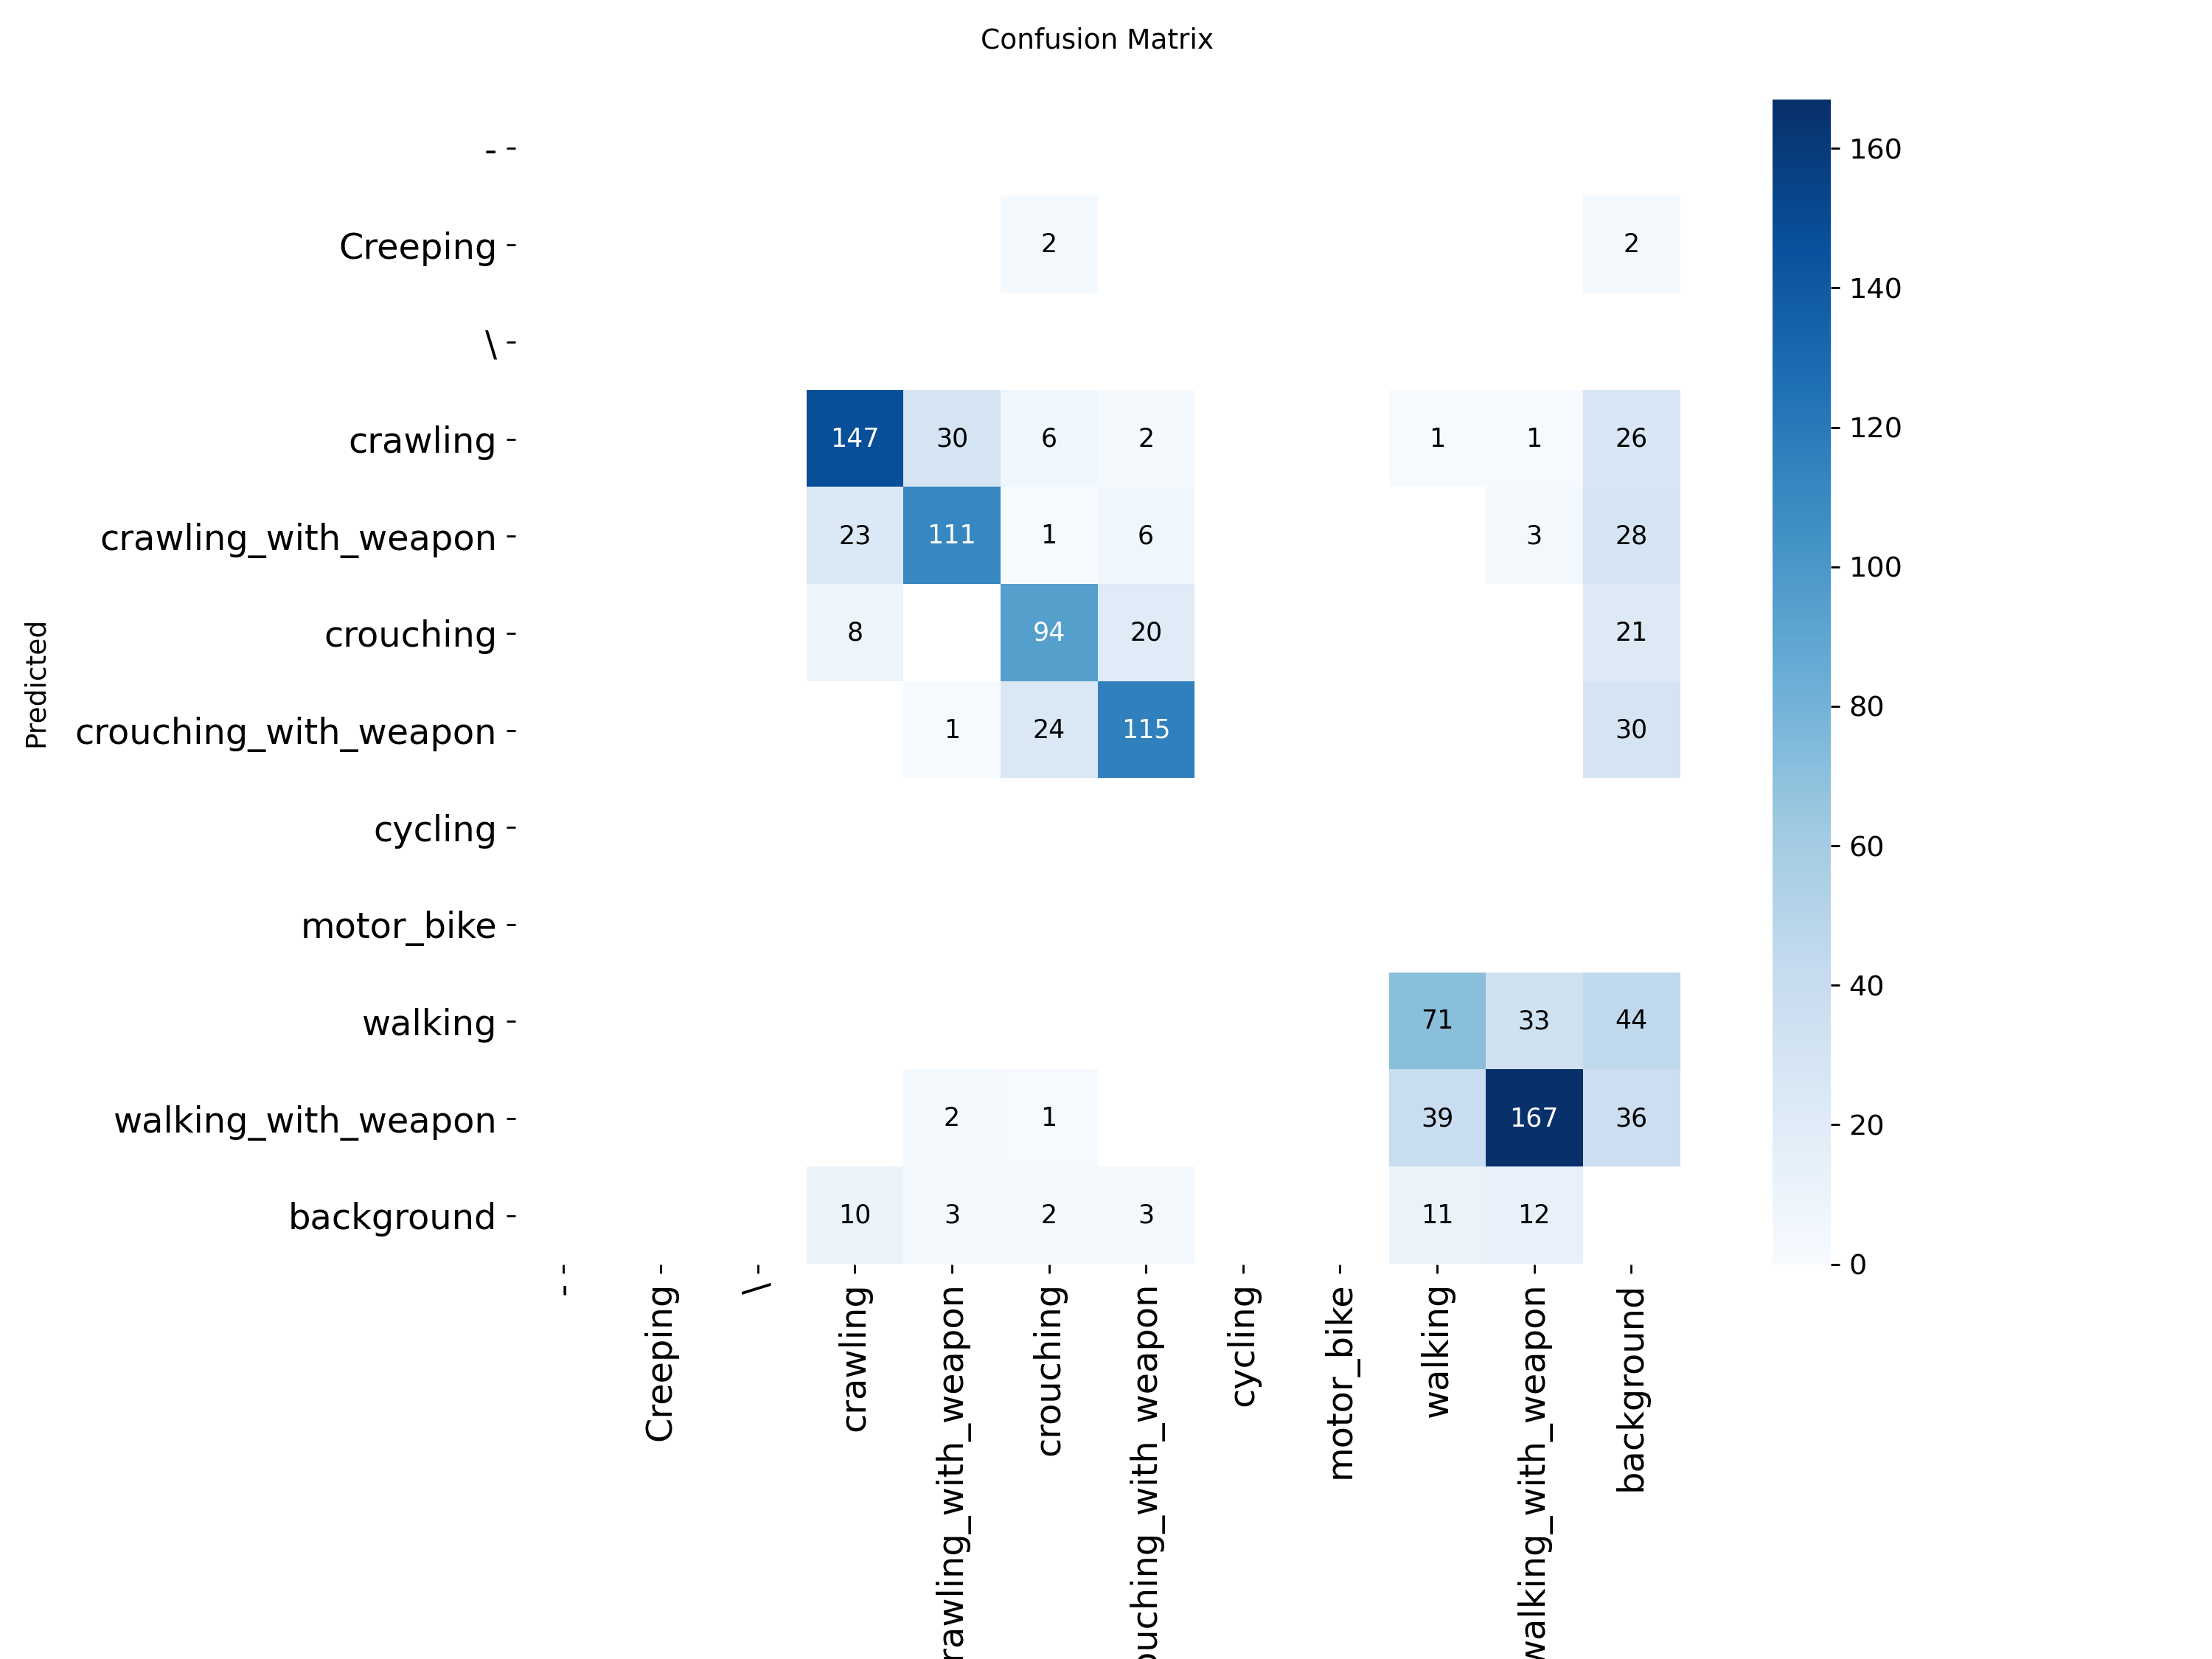

In [11]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

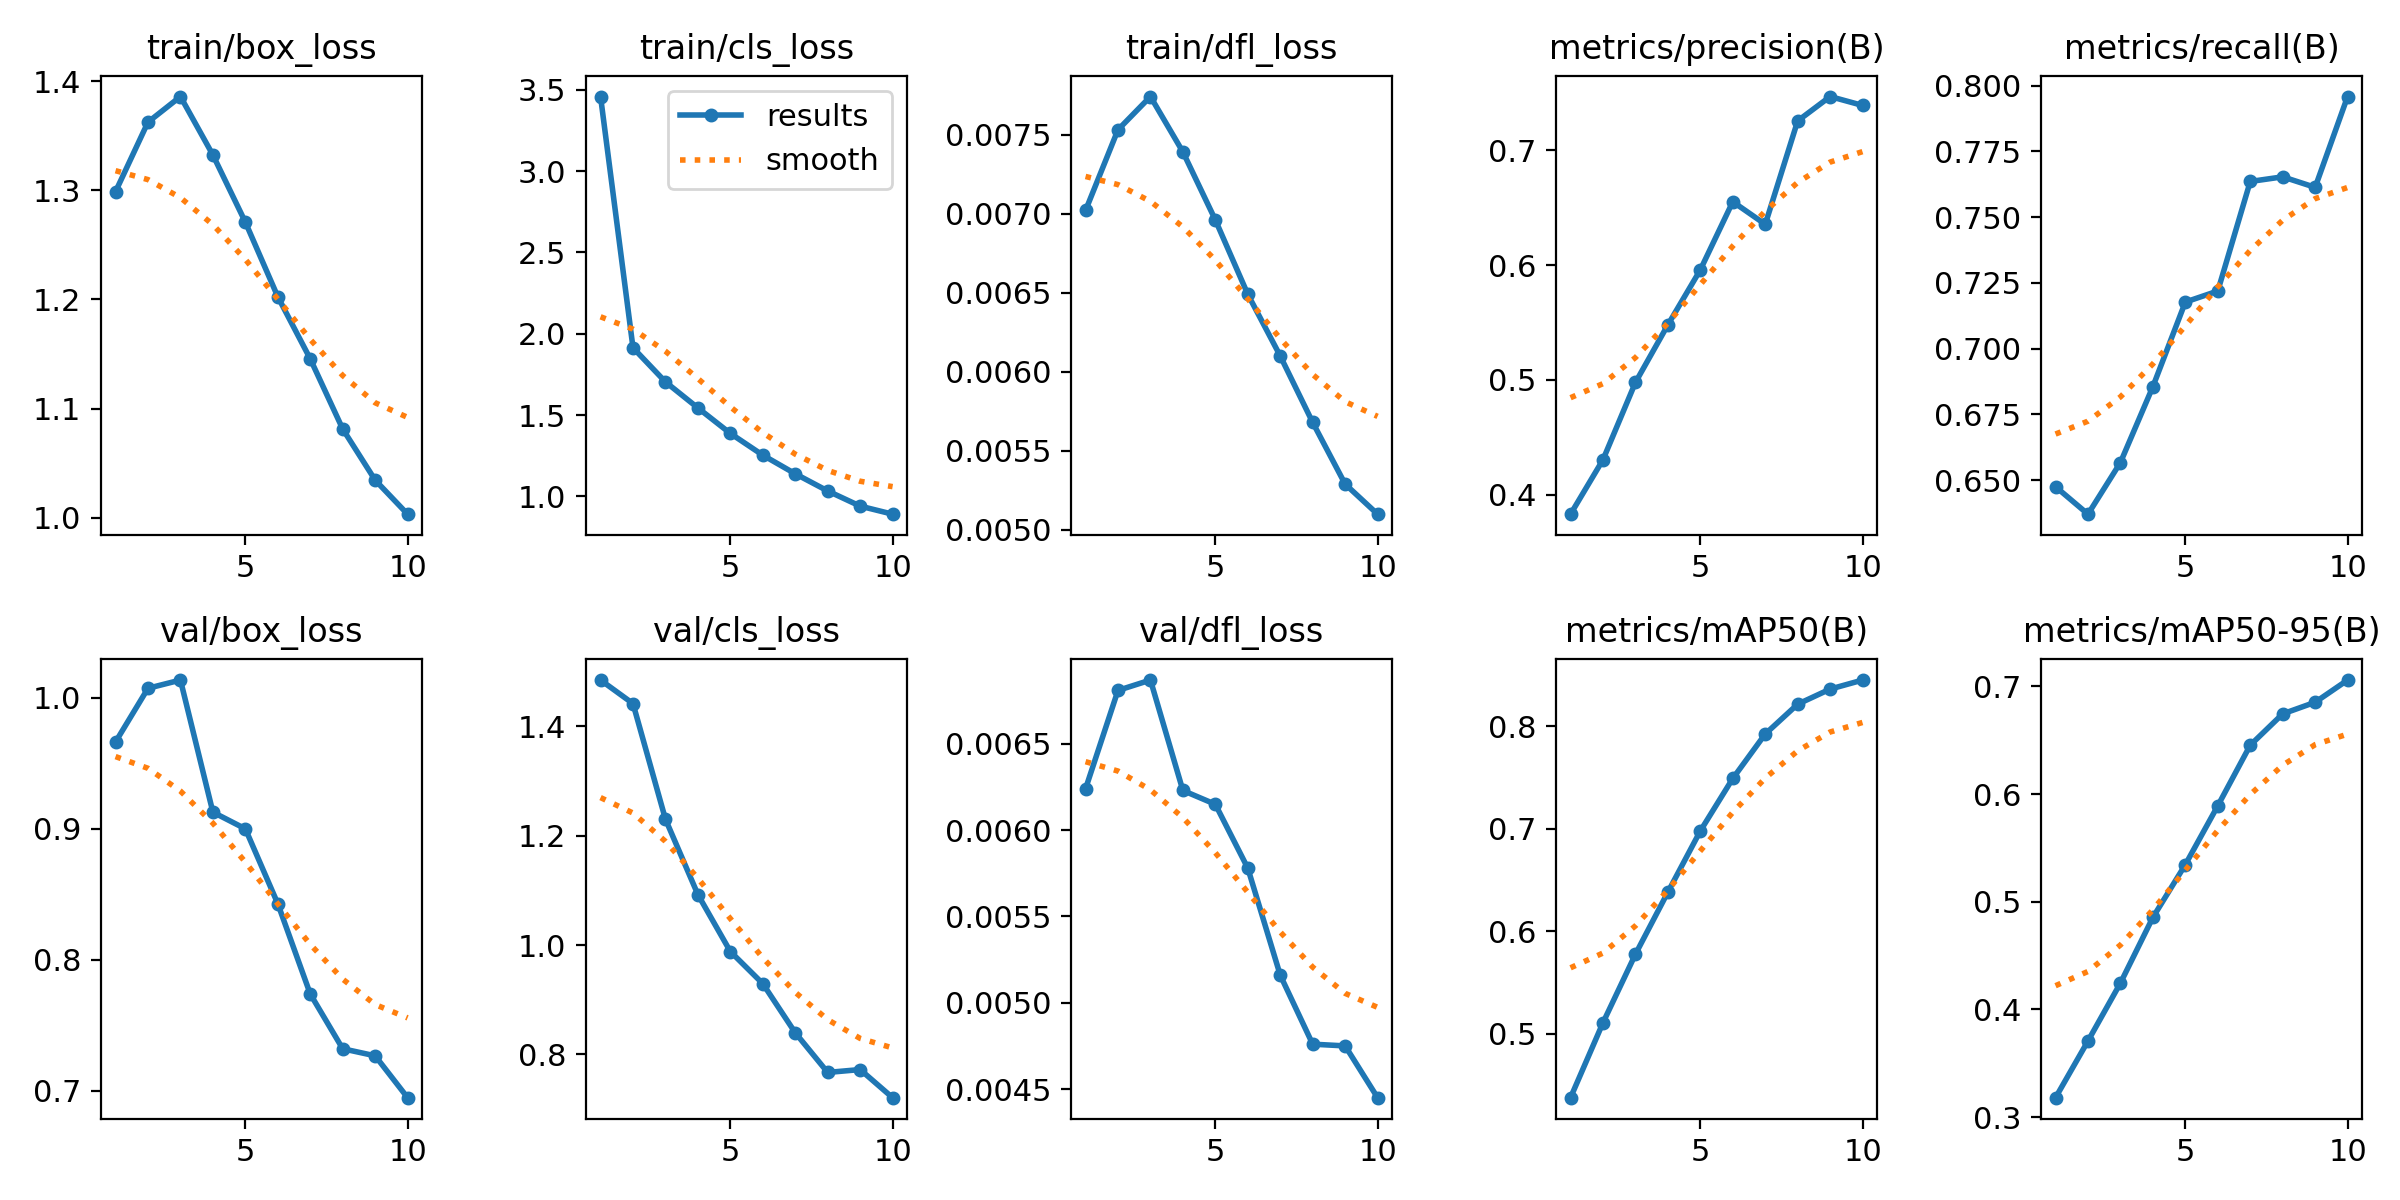

In [12]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

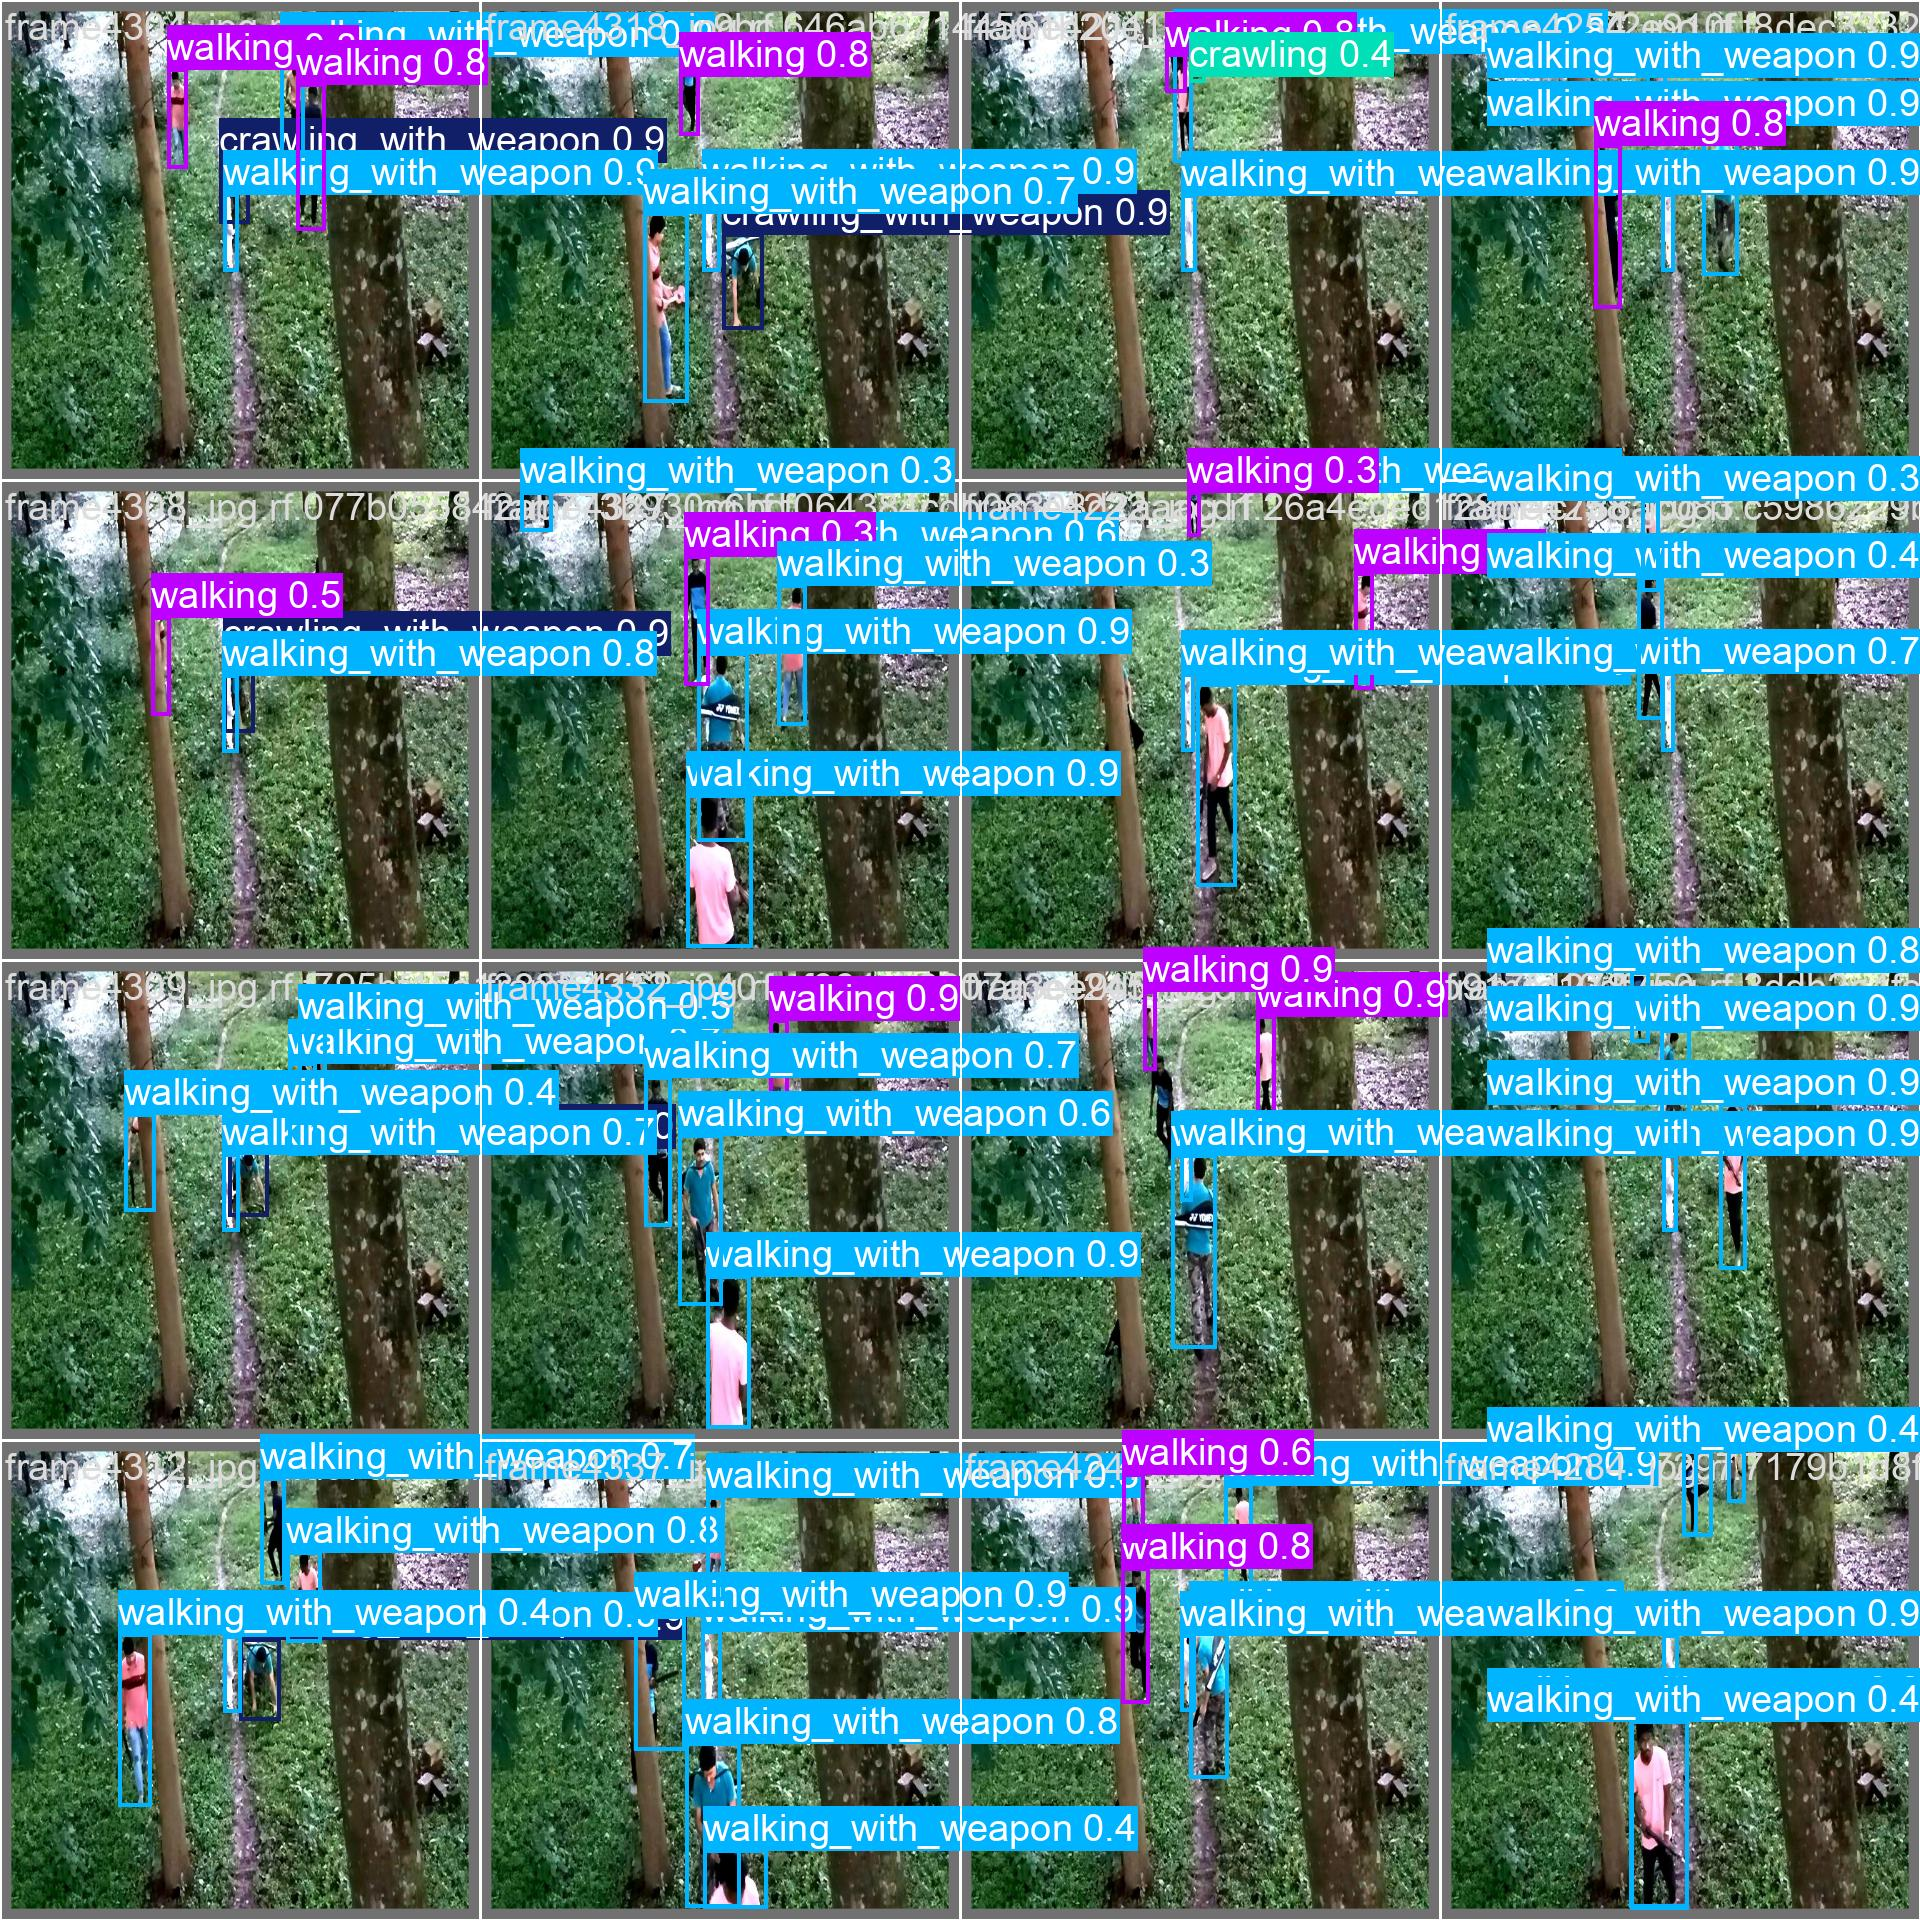

In [13]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

In [14]:
!yolo task=detect mode=val model={HOME}/runs/detect/train2/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26m summary (fused): 132 layers, 20,357,933 parameters, 0 gradients, 67.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2193.3±251.7 MB/s, size: 121.3 KB)
val: Scanning /content/datasets/Security_Surveillance-1/valid/labels.cache... 303 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 303/303 41.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9it/s 9.9s
                   all        303        949      0.741      0.795      0.845      0.705
              crawling        136        188      0.792       0.83      0.872      0.731
  crawling_with_weapon        108        147      0.757      0.837       0.89      0.784
             crouching        104        130      0.765      0.776      0.856      0.735
 crouching_with_weapon         99        146      0.765      0.856      0.899      0.791
               walki

---

In [15]:
from ultralytics import YOLO

model = YOLO(f'{HOME}/runs/detect/train2/weights/best.pt')

In [16]:
import supervision as sv

ds_test = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

In [17]:
import supervision as sv
from PIL import Image

def annotate(image: Image.Image, detections: sv.Detections) -> Image.Image:
    color = sv.ColorPalette.from_hex([
        "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00",
        "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    ])

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    box_annotator = sv.BoxAnnotator(color=color)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        smart_position=True
    )

    out = image.copy()
    out = box_annotator.annotate(out, detections)
    out = label_annotator.annotate(out, detections)
    out.thumbnail((1000, 1000))
    return out

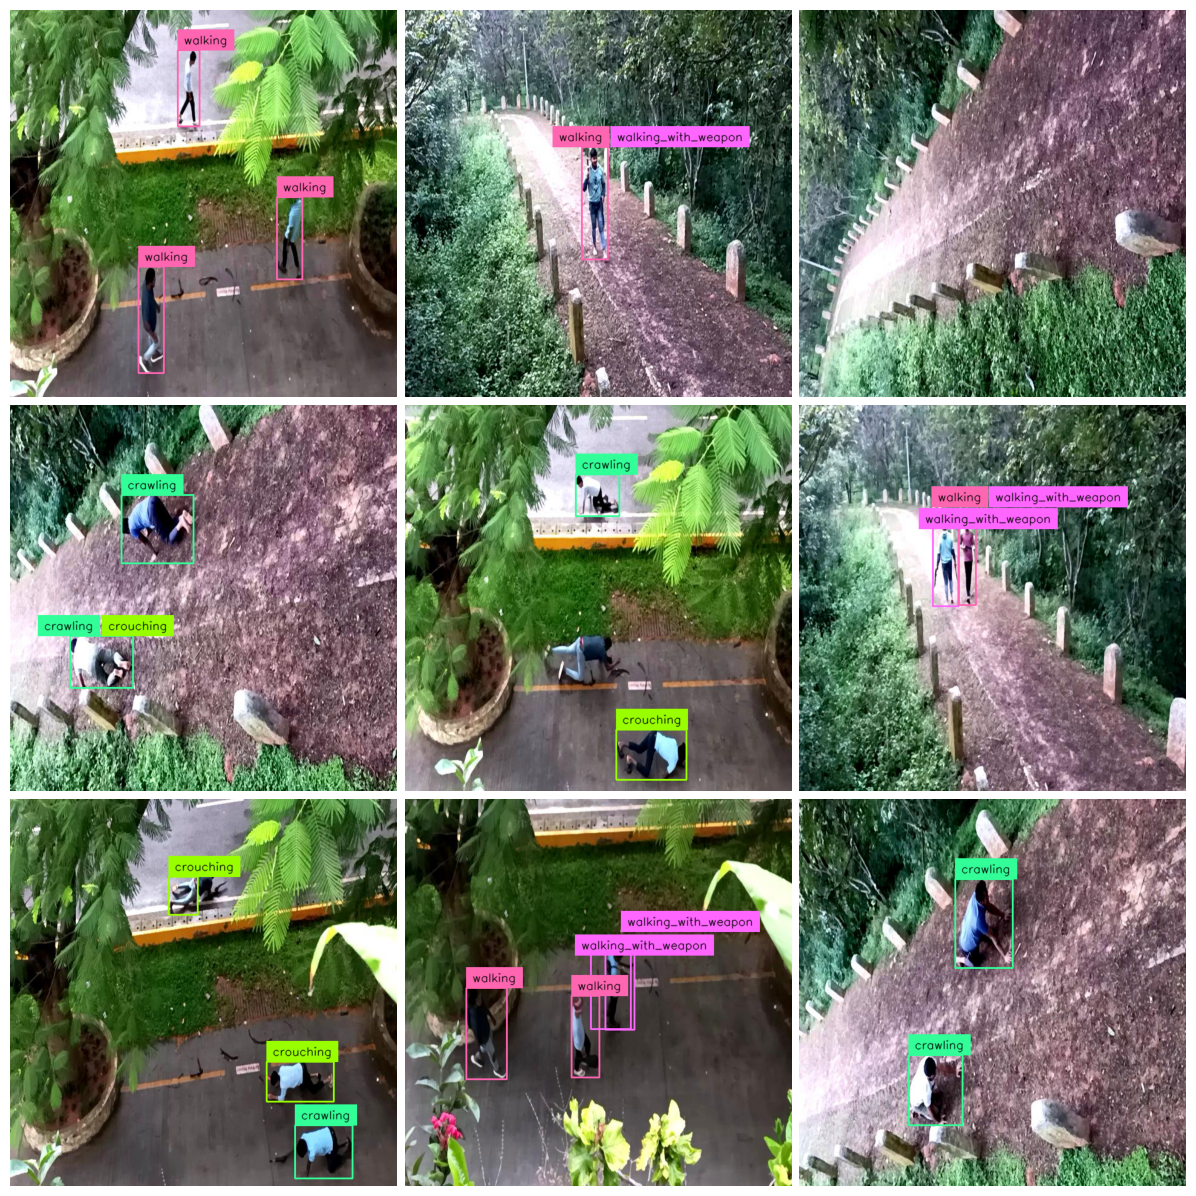

In [18]:
import random
import matplotlib.pyplot as plt

N = 9
L = len(ds_test)

annotated_images = []

for i in random.sample(range(L), N):
    path, _, annotations = ds_test[i]
    image = Image.open(path)
    result = model.predict(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)
    annotated_image = annotate(image, detections)
    annotated_images.append(annotated_image)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, img in zip(axes.flat, annotated_images):
    ax.imshow(img)
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.99, bottom=0.01)

plt.show()

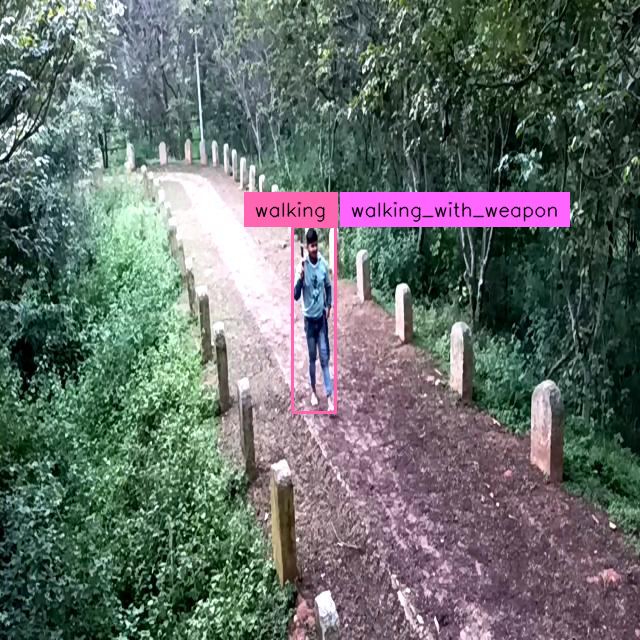

In [21]:
annotated_images[1]

In [20]:
from google.colab import files

files.download('/content/runs/detect/train2/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>